# Relevant Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import autograd.numpy as np
import autograd.scipy.stats as stats
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model
from numpy.linalg import LinAlgError

# Week 1

In [2]:
# Generate datapoints
l = 100
dim = 1
d = np.random.rand(l, dim) * 20
noise = 1 # sigma^2_y
def augment_d(d): # Augments dataset with an intercept column
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
eps = np.random.randn(l) * np.sqrt(noise)

true_weights = np.array([-9, 15]) # Underlying data-generating weights
y = augment_d(d) @ true_weights + eps

In [3]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    _, log_det = np.linalg.slogdet(cov)
    cov_inv = np.linalg.inv(cov)
    prod = x_mu.T @ cov_inv @ x_mu
    log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob
log_pdf = stable_multivariate_gaussian_logpdf

In [4]:
mu_prior = np.array([19, 5])
cov_prior = np.array([[20, 0.3], [0.3, -3]]) * 20

In [5]:
def analytical_posterior_pdf(theta, d, y): # Compute pdf
    l = len(d)
    mu = mu_prior + cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return np.exp(stable_multivariate_gaussian_logpdf(theta, mu, cov))

def analytical_posterior_params(d, y, mu_prior=mu_prior, cov_prior=cov_prior): # Get parameters of pdf
    l = len(d)
    mu = mu_prior + cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ (y - d @ mu_prior)
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(l)) @ d @ cov_prior
    return mu, cov


In [6]:
true_weights

array([-9, 15])

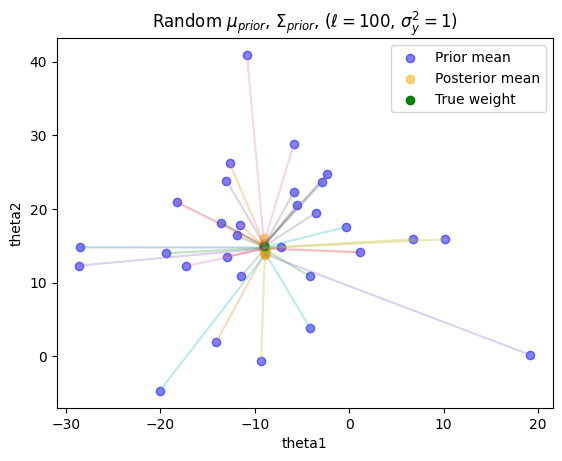

In [7]:
N = 30
mu_prior_samples = (np.random.randn(N, 2))*10 + true_weights
cov_prior_samples = np.tile(np.eye(2), (N, 1, 1))
mus = np.array([analytical_posterior_params(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)[0] for mu_prior, cov_prior in zip(mu_prior_samples, cov_prior_samples)])

#plt.scatter([(eigen[0], eigen[1]) for eigen in np.linalg.eigen(covs)])
for prior, posterior in zip(mu_prior_samples, mus):
    plt.plot([prior[0], posterior[0]], [prior[1], posterior[1]], alpha=0.3)
plt.scatter(mu_prior_samples[:, 0], mu_prior_samples[:, 1], color="blue", label="Prior mean", alpha=0.5)
plt.scatter(mus[:, 0], mus[:, 1], color="orange", label="Posterior mean", alpha=0.5)
plt.scatter(true_weights[0], true_weights[1], color="green", label="True weight")
#plt.xlim(-40, 10)
#plt.ylim(-10,40)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("Random $\mu_{prior}$, $\Sigma_{prior}$, ($\ell = %d$, $\sigma^2_y = %d$)" % (l, noise))
plt.legend()

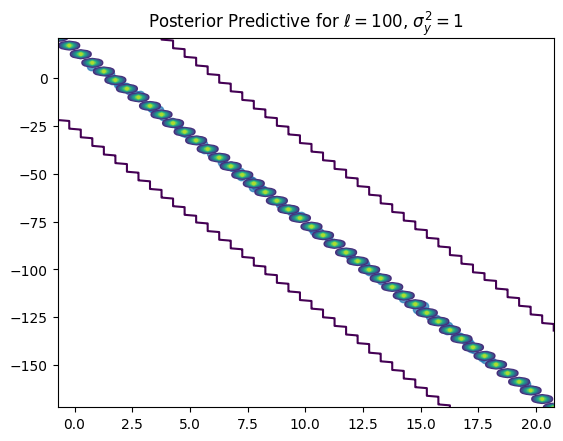

In [7]:
def plot_predictive(mean, cov, x, y):
    # Define the grid for the contour plot
    plt.scatter(x, y, alpha=0.7)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    x_grid, y_grid = numpy.mgrid[xmin:xmax:.5, ymin:ymax:.5]

    pos = np.empty(x_grid.shape + (2,))
    pos[:, :, 0] = x_grid
    pos[:, :, 1] = y_grid
    #print(np.dstack((x_grid, y_grid)))
    z = []

    # Create a multivariate normal distribution
    for row in np.dstack((x_grid, y_grid)):
        row_x = augment_d(np.array([row[:, 0]]).T)
        row_y = np.array([row[:, 1]])
        #row_z = scipy.stats.multivariate_normal.pdf(row_y, row_x @ mean, np.var(y)*np.eye(len(row_x)) + row_x @ cov @ row_x.T)
        #print(row_z)
        row_z = []
        for [x_p, y_p] in row:
            #p = np.array([x_var, y_var])
            x_p = np.array([x_p, 1])
            rv = scipy.stats.multivariate_normal(x_p.T @ mean, noise + x_p.T @ cov @ x_p)
            # Evaluate the probability density function on the grid
            row_z.append(rv.pdf(y_p))
        z.append(np.array(row_z))
    z = np.array(z).reshape(x_grid.shape)
    # Plot the scatter plot
    plt.contour(x_grid, y_grid, z)
    ones = np.ones((len(np.linspace(xmin, xmax)), 1))
    x_aug = np.concatenate((np.linspace(xmin, xmax).reshape(len(ones), 1), ones), axis=1)
    #plt.plot(np.linspace(xmin, xmax).reshape(len(ones), 1), f(x_aug, mean), c='purple', label="Mean Parameter Estimate")
    #plt.legend()
    plt.title("Posterior Predictive for $\ell = %d$, $\sigma^2_y = %d$" % (l, noise))
    plt.show()
params = analytical_posterior_params(augment_d(d), y)
plot_predictive(params[0], params[1], d, y)

# Week 2

In [8]:
def mutual_information(d):
    l = len(d)
    M = 2
    N = 5
    samples = []
    thetas = np.random.multivariate_normal(mu_prior, cov_prior, size=N)
    for theta in thetas:
        ys = ((np.tile(augment_d(d), (M, 1, 1)) @ theta).T + (noise * np.eye(len(d))) @ np.random.randn(len(d), M)).T
        for y in ys:
            mu_post, cov_post = analytical_posterior_params(augment_d(d), y, mu_prior=mu_prior, cov_prior=cov_prior)
            val = stable_multivariate_gaussian_logpdf(theta, mu_post, cov_post) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_prior))
            samples.append(val)
    return 1/(N * M) * np.sum(samples)

In [9]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=False):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        if not callback(x, g):
            break
    return x


In [10]:
def decode_d(encoded_d, dim=1):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

In [11]:
def optimize(g, d0, alpha, beta, c, iterations, callback=lambda _: True):
    d = d0
    for i in range(int(iterations)):
        d = d - alpha / (10**c + i * 10**(-beta)) * g(d)
        if not callback(d):
            break
    return d

In [12]:
mu_prior = np.array([180, -77, 90])
cov_prior = np.eye(3)
d0 = np.array([[0,0] for _ in range(10)])
dis = []
dis.append(d0)
mis = []
def callback(di):
    dis.append(decode_d(di, dim=2))
    return True

def g(di):
    di = decode_d(di, dim=2)
    gra = grad(lambda di: -mutual_information(di))(di)
    mis.append(mutual_information(di))
    reg_term = 1e-2 * 2 * encode_d(di) # L2 norm gradient
    return encode_d(gra)
optimize(g, encode_d(d0), 1, 2, 0, 1e3, callback=callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.2)
plt.title("Points move per iteration (zero mean, regularized)")

NameError: name 'dis' is not defined

In [14]:
plt.plot(list(range(len(mis))), mis)
plt.title("MI (non-zero-mean)")
plt.xlabel("Iteration")
plt.ylabel("MI")

NameError: name 'mis' is not defined

# Week 3-4

In [12]:
def encode_q_params(q_params): # mean, A to vector
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))
def decode_q_params(encoded_q, dim = 3): # vector to mean, A
    shape = len(encoded_q)
    A_shape = (int(np.sqrt(shape - dim)), int(np.sqrt(shape - dim)))
    mean = encoded_q[0:dim]
    A = encoded_q[dim:shape].reshape(A_shape)
    return mean, A

In [13]:
def log_likelihood(y, theta, d):
    return log_pdf(y, d @ theta, noise * np.eye(len(y)))

In [14]:
def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))


In [15]:
def ELBO(d, y, mean, A): # optimizing for mean, A
    zs = np.random.normal(size=(N, len(mean))) # N samples of size d
    likelihood_samples = []
    for z in zs:
        theta = mean + A @ z
        likelihood_samples.append(log_likelihood(y, theta, d))
    return 1/N * np.sum(likelihood_samples, axis=0) - KLD(mean, A, mu_prior, A_prior)


In [19]:
log_pdf = stable_multivariate_gaussian_logpdf
d = np.random.randn(100,2)
A_prior = np.array([[5, -2, 1],
              [-2, 4, -1],
              [1, -1, 3]])
cov_prior = A_prior @ A_prior.T
mu_prior = np.array([7, -4, 1])
noise = 0.8
true_weights = np.array([18, -1, -15])
y = (augment_d(d) @ np.array([true_weights]).T + np.random.randn() * noise).T[0]
mu0 = mu_prior
A0 = A_prior

def callback(encoded_q_params, g):
    qs.append(encoded_q_params)
    return True

def objective_f(encoded_q_params):
    mean, A = decode_q_params(encoded_q_params)
    elbo = ELBO(augment_d(d), y, mean, A)
    elbos.append(elbo._value)
    return -elbo
qs = []
elbos = []
optimizer(encode_q_params((mu0, A0)), grad(objective_f), iters=5e2, callback=callback, rate=1e-3, decay=1e-5)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

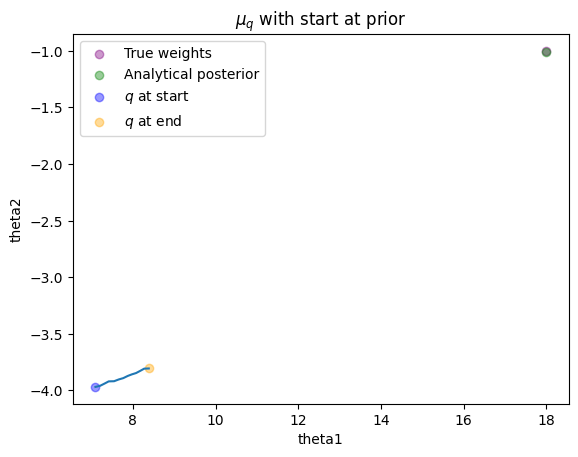

In [20]:
qsa = np.array(qs)
plt.plot(qsa[:, 0], qsa[:,1])
analytical_theta = analytical_posterior_params(augment_d(d), y, mu_prior, cov_prior)
plt.scatter(true_weights[0], true_weights[1], color="purple", label="True weights", alpha=0.4)
plt.scatter(analytical_theta[0][0], analytical_theta[0][1], color="green", label="Analytical posterior", alpha=0.4)
plt.scatter(qsa[0,0], qsa[0,1], color="blue", label="$q$ at start", alpha=0.4)
plt.scatter(qsa[-1,0], qsa[-1,1], color="orange", label="$q$ at end", alpha=0.4)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("$\mu_q$ with start at prior")
plt.legend()

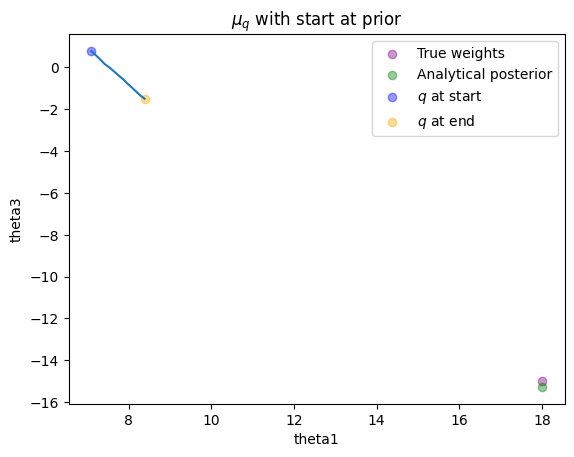

In [21]:
qsa = np.array(qs)
plt.plot(qsa[:, 0], qsa[:,2])
analytical_theta = analytical_posterior_params(augment_d(d), y, mu_prior, cov_prior)
plt.scatter(true_weights[0], true_weights[2], color="purple", label="True weights", alpha=0.4)
plt.scatter(analytical_theta[0][0], analytical_theta[0][2], color="green", label="Analytical posterior", alpha=0.4)
plt.scatter(qsa[0,0], qsa[0,2], color="blue", label="$q$ at start", alpha=0.4)
plt.scatter(qsa[-1,0], qsa[-1,2], color="orange", label="$q$ at end", alpha=0.4)
plt.xlabel("theta1")
plt.ylabel("theta3")
plt.title("$\mu_q$ with start at prior")
plt.legend()

Text(0, 0.5, 'ELBO')

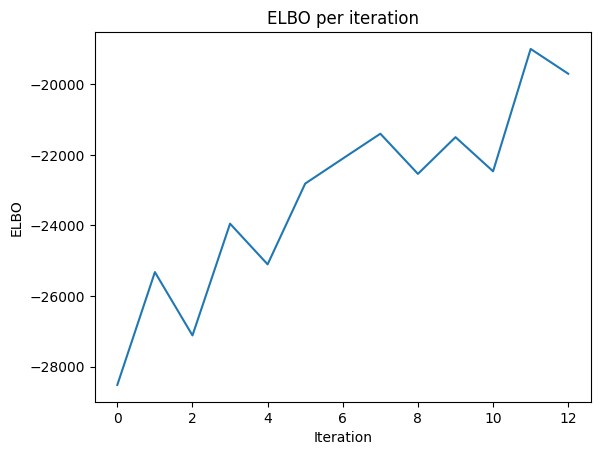

In [22]:
plt.title("ELBO per iteration")
plt.plot(np.arange(0, len(elbos)), elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

# Week 5-6

Does not work as of yet. 

In [16]:
def MI_grad(d): # Version 1 - autograd of log-posterior. Is almost working, but produces a lot of noise
    N = 5
    M = 1
    results = []
    eps = np.random.randn(N, len(d)) * np.sqrt(noise)
    for i in range(N):
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mu_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                mean, cov = analytical_posterior_params(augment_d(d), y_ij, mu_prior=mu_prior, cov_prior=cov_prior)
                return mean, np.linalg.cholesky(cov)
            def q_(theta, lam):
                mean, A = lam
                return stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T)
            results.append(encode_d(grad(lambda d: q_(theta_j, g(d)))(d)))
    return decode_d(np.mean(np.array(results), axis=0), dim=2)

In [17]:
def MI_grad_2(d): # Version 2 - autograd of posterior. Seems to work as well as version 1.
    N = 5
    M = 1
    results = []
    eps = np.random.randn(N, len(d)) * np.sqrt(noise)
    for i in range(N):
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mu_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                mean, cov = analytical_posterior_params(augment_d(d), y_ij, mu_prior=mu_prior, cov_prior=cov_prior)
                return mean, np.linalg.cholesky(cov)
            def q_(theta, lam):
                mean, A = lam
                return stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T)
            results.append(1/np.exp(q_(theta_j, g(d))) * grad(lambda d: np.exp(q_(theta_j, g(d))))(d))
    return np.mean(np.array(results), axis=0)

In [18]:
def reshape_jacobian(jac):
    return np.array([encode_d(jac[i]) for i in range(jac.shape[0]) ])
def MI_grad_3(d): # Version 3 - autograd of Jacobian. Does not work.
    N = 5
    M = 1
    results = []
    eps = np.random.randn(N, len(d)) * np.sqrt(noise)
    for i in range(N):
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mu_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                mean, cov = analytical_posterior_params(augment_d(d), y_ij, mu_prior=mu_prior, cov_prior=cov_prior)
                return mean, np.linalg.cholesky(cov)
            def q_(theta, lam):
                mean, A = lam
                return stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T)
            q_params = g(d)
            g1 = encode_q_params(grad(lambda lam: q_(theta_j, lam))(q_params))
            g2 = reshape_jacobian(jacobian(lambda d: encode_q_params(g(d)))(d))
            actual = g1 @ g2
            c_part = 1/q_(theta_j, q_params)
            results.append(c_part * actual)
    return np.mean(np.array(results), axis=0)

In [19]:
def q_grad(theta, q_params, d, y_i):
    q_mean, q_A = q_params
    inverse_hessian = np.linalg.inv(hessian(lambda eq: ELBO(augment_d(d), y_i, decode_q_params(eq)[0], decode_q_params(eq)[1]))(encode_q_params(q_params)))
    mixed_partials = jacobian(lambda eq: grad(lambda d: ELBO(augment_d(decode_d(d, dim=2)), y_i, decode_q_params(eq)[0], decode_q_params(eq)[1]))(encode_d(d)))(encode_q_params(q_params)).T
    jac = - inverse_hessian @ mixed_partials
    return jac

def MI_grad_4(d): # Version 4 - entire gradient with analytical posterior. Does not work
    N = 5
    M = 1
    results = []
    eps = np.random.randn(N, len(d)) * np.sqrt(noise)
    for i in range(N):
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mu_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                mean, cov = analytical_posterior_params(augment_d(d), y_ij, mu_prior=mu_prior, cov_prior=cov_prior)
                return mean, np.linalg.cholesky(cov)
            def q_(theta, lam):
                mean, A = lam
                return stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T)
            q_params = g(d)
            g1 = encode_q_params(grad(lambda lam: q_(theta_j, lam))(q_params))
            g2 = q_grad(theta_j, q_params, d, y_ij)
            actual = g1 @ g2
            c_part = 1/q_(theta_j, q_params)
            results.append(c_part * actual)
    return np.mean(np.array(results), axis=0)

In [20]:
def MI_grad_5(d): # Version 5 - entire gradient with variational posterior. Does not work.
    N = 5
    M = 1
    results = []
    eps = np.random.randn(N, len(d)) * np.sqrt(noise)
    for i in range(N):
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mu_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                mean, cov = analytical_posterior_params(augment_d(d), y_ij, mu_prior=mu_prior, cov_prior=cov_prior)
                return mean, np.linalg.cholesky(cov)
            def q_(theta, lam):
                mean, A = lam
                return stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T)
            
            def inner_objective_f(encoded_q_params):
                mean, A = decode_q_params(encoded_q_params)
                elbo = ELBO(augment_d(d), y_ij, mean, A)
                return -elbo
            q_params = decode_q_params(optimize(grad(inner_objective_f), encode_q_params((mu_prior, A_prior)), 1e-1, 2, 0, 1e2))
            g1 = encode_q_params(grad(lambda lam: q_(theta_j, lam))(q_params))
            g2 = q_grad(theta_j, q_params, d, y_ij)
            actual = g1 @ g2
            c_part = 1/q_(theta_j, q_params)
            results.append(c_part * actual)
    return np.mean(np.array(results), axis=0)

In [22]:
mu_prior = np.array([0, 0, 0])
A_prior = np.eye(3)
cov_prior = A_prior @ A_prior.T
d0 = np.array([[0,0] for _ in range(10)])
dis = []
dis.append(d0)
mis = []
def g(di):
    di = decode_d(di, dim=2)
    gra = -MI_grad_5(di) # Change here to try different implementations of the gradient.
    mis.append(mutual_information(di))
    reg_term = 1e-2 * 2 * encode_d(di) # L2 norm gradient
    return encode_d(gra)

def callback(di):
    print("Outer di ", np.linalg.norm(di), " len ", len(dis))
    dis.append(decode_d(di, dim=2))
    return True
optimize(g, encode_d(d0), 1e-5, 2, 0, 1e4, callback=callback)

Outer di  0.037919690257338746  len  1
Outer di  0.04437010682500323  len  2
Outer di  0.04950666452923199  len  3
Outer di  0.04906441810388617  len  4
Outer di  0.05374382496960846  len  5
Outer di  0.06570368527954923  len  6
Outer di  0.10875099039113276  len  7
Outer di  0.10892890790776494  len  8
Outer di  0.09814807215244345  len  9
Outer di  0.09698421569170473  len  10
Outer di  0.1014397448895507  len  11
Outer di  0.10132023934076347  len  12
Outer di  0.24658720031249232  len  13
Outer di  0.25563985282665536  len  14
Outer di  0.25215338073542254  len  15
Outer di  0.25262734378170865  len  16
Outer di  0.28025270039868067  len  17
Outer di  0.2808372979585202  len  18
Outer di  0.2807891056020551  len  19
Outer di  0.29115561944308815  len  20
Outer di  0.2919101827785592  len  21
Outer di  0.291838296282941  len  22
Outer di  0.2942610662624181  len  23
Outer di  0.2934705885601139  len  24
Outer di  0.29436874930314605  len  25
Outer di  0.29198374347363815  len  26
Ou

KeyboardInterrupt: 

Notice how the following plot is scattered and kind of converges, which is different than the other solution

Text(0.5, 1.0, 'Points move per iteration')

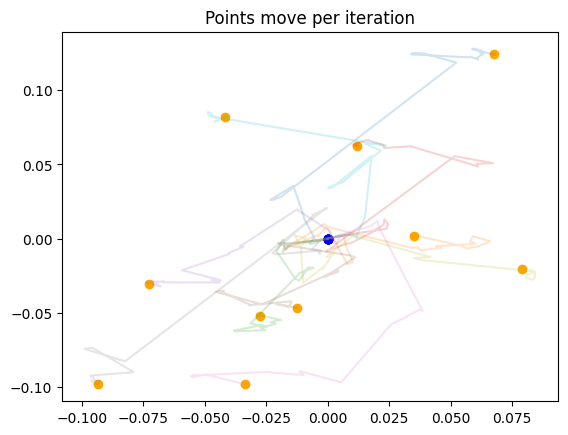

In [23]:
dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.2)
plt.title("Points move per iteration")

Text(0, 0.5, 'MI')

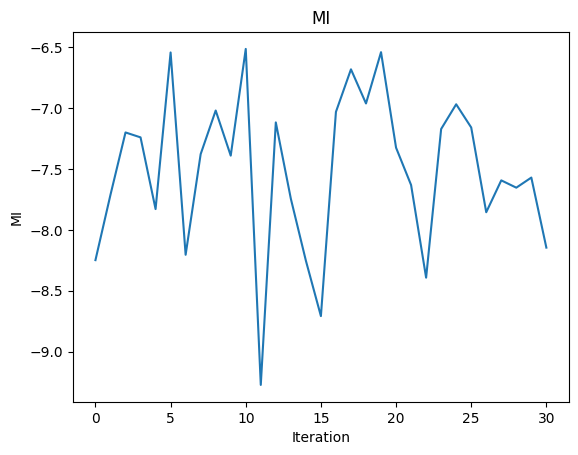

In [25]:
plt.plot(list(range(len(mis))), mis)
plt.title("MI")
plt.xlabel("Iteration")
plt.ylabel("MI")

In [45]:
dis

array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-5.51106258e-01,  3.95888836e-01],
        [-2.41638369e+00,  6.80713940e-01],
        [-5.57453806e-01,  6.47899404e-01],
        [-1.95574308e-01,  3.64202868e-01],
        [ 3.42690665e+00, -1.74192080e+00],
        [ 1.33347241e+00, -9.60811760e-01],
        [-1.04660999e+00,  1.67936783e-01],
        [-2.52340260e-01,  9.96334010e-03],
        [ 1.35055066e+00, -4.23065522e-01],
        [ 4.23976529e-01, -1.59847840e-01]],

       [[ 7.64009897e+05, -6.82131818e+06],
        [-1.13682149e+07, -2.19399751e+07],
        [ 2.45281306e+06, -8